#Import required libraries

In [ ]:
!pip install numpy==1.24.2
!pip install pyLDAvis
!pip install gensim

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LsiModel, Phrases, LdaModel, TfidfModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis.lda_model
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import spacy
nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


#Data Cleaning

In [ ]:
# Download the original raw file from gdrive and unzip it
!gdown 1Tf3xXiHyYJC2ySFmacaiBnQthQv53AaQ
!unzip raw-dataset.zip

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Downloading...
From: https://drive.google.com/uc?id=1Tf3xXiHyYJC2ySFmacaiBnQthQv53AaQ
To: /content/raw-dataset.zip
100% 33.4M/33.4M [00:00<00:00, 36.1MB/s]
Archive:  raw-dataset.zip
  inflating: dataset.csv             


In [ ]:
# The longest document is 39238 chars long
# the line below allows you to view each document fully
# pd.set_option('display.max_colwidth', 39238)

# load the csv into a df
df = pd.read_csv("dataset.csv")
df = df[['selftext']]
df.rename(columns={'selftext': 'document'}, inplace=True)

# Sort by length of documents
df = df.sort_values(by='document', key=lambda x: x.str.len(), ascending=False)
df.reset_index(drop=True, inplace=True)

df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-140-55d8bdb85062>:6: DtypeWarning: Columns (0,3,4,6,7,8,9,13,14,15,17,18,19,20,21,22,23,25,26,27,29,32,33,35,36,38,41,42,43,46,47,48,54,55,56,57,63,64,67,69,70,75,78,82,83,91,92,93,97,99,100,102,103,104,105,106,107,109,111,112,114,115,116,118,122,123,124) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset.csv")


document
0      This is for people who are curious about how we could ever figure out conclusively what is the most rational thing to believe about the existence of God, or who are interested in a philosophical approach to belief or disbelief in God and how that relates to Islam and the Quran.\n\nWe can begin by asking ourselves some questions.\n\nIf we were not conscious, would God exist? This question is based on the false premise that consciousness is a determinant of the existence or nonexistence of God. Consciousness entails the *assessment* of God’s existence. Being unconscious eliminates both propositions of acceptance and rejection from an individual perspective.\n\nHow does consciousness relate to the actual existence of God then? This question is posed from the assumed premise that consciousness is related to the actual existence or nonexistence of God at all, and cannot be soundly answered from reason since the answer could only be from conjecture when already given one of the two realities as it ties to the conclusion. The premise of being *in relation to God’s existence* disqualifies the entry of any strictly deductible answer. The answers would otherwise be that consciousness is necessarily dependent on God or that consciousness is independent of God. Neither proposition is a deductible standalone statement if we were to start our discussion of evaluating God from the existence of consciousness.\n\nFinally then, how can we know if God exists or does not exist? **Reason** is the only individual faculty a consciousness has to determine Truth. Therefore, we **must use reason**.\n\nWe question ourselves, what is possible to firmly, certainly, and deductively conclude about God given the nature of consciousness and reason existing in reality and in relation to what is a part of reality?\n\nDEDUCTIVE PROOF OF ISLAM BY METAPHYSICAL FINALITY\n\n**Metaphysical Finality** is the singular, ultimately True nature of reality as it relates conscious being to the concurrent existence and acceptance of God or the concurrent nonexistence and rejection of God, either option being *only* concurrent as a necessity of the ultimate determination of sound reason being Truth.\n\nAtheism has no ontological or metaphysical soundness due to the fact that one can never prove or substantiate the nonexistence of God, but it can be accepted as a faith or belief from a position of Ego. We cannot deductively assert Atheism. This statement is sound due to the metaphysical impossibility of proving the nonexistence of God, which is the main assertion and definition of Atheism. Atheism is not a valid contention on the premise of there being inference from observation enough to negate the existence of God since the nature of this argument is metaphysical in reference to God and necessarily requires metaphysical inferences and proof outside of what would otherwise be an invalid and circular naturalistic framework of assessment. Moreover, supposed claims on God as a reality being impossible based upon presumed limitations to the nature of God is a fallacious act of circular reasoning embedded in one’s own imagined premises of what that God is then. We know that in Islam and even broadly speaking about God in reference to the ontological proof and hierarchies of Being, God is without contingency and outside of the hierarchy of Being as he is not limited to any construct but is the founder of *all* physical and abstract constructs. But to reiterate the point, it is not valid reason in pointing to a lack of apparent supernatural influence from God in the world to form a substantial inference suggesting that God is nonexistent, because metaphysically, one can also simply understand that everything in the world is actively from God, making everything equally a proof for God’s existence - a stark parallel to atheist logic, although what makes Belief more valid than Disbelief here is that Belief follows the principles of understanding Hierarchies of Being whe

In [ ]:
print("Number of rows before:", df.shape[0])
df=df.drop_duplicates().dropna().reset_index(drop=True)
print("\nNumber of rows after dropping duplicates and nulls:", df.shape[0])

Number of rows before: 40287

Number of rows after dropping duplicates and nulls: 39998


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Lemmatization generally results in better coherence of topics and improves topic interpretability by reducing words to their base form, which helps to group together words with similar meanings and also reduces redundancy.

Characters that aren't part of the alphabet don't help with topic interpretability so I removed them.

Single/double letter words present in the reviews, that were usually not helpful in interpreting topics, were also removed.

##Rough Visualisations

In [ ]:
#REMOVE LATER
# !gdown 1VKU-xxrRCn1P-1LOpfTB33N9h8Jwd6Bb
dfcleanv3 = pd.read_csv("/content/Reddit-Islam-clean-v3.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pandas as pd

dfplot = dfcleanv3
title = "After Preprocessing"
# Split the text into words and calculate word lengths
words = ' '.join(dfplot['document']).split()
word_lengths = [len(word) for word in words]

# Calculate the mean, maximum, and minimum word lengths
mean_word_length = sum(word_lengths) / len(word_lengths)
max_word_length = max(word_lengths)
min_word_length = min(word_lengths)

# Create a DataFrame with the statistics
stats_df = pd.DataFrame({
    "Title:": ["Mean Word Length", "Maximum Word Length", "Minimum Word Length"],
    title : [f"{mean_word_length:.2f} letters", f"{max_word_length} letters", f"{min_word_length} letters"]
})

# Print the DataFrame
stats_df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def doclength_hist(dfplot, title, xrange=(0, 3000)):
    # Calculate document lengths and add them to the DataFrame
    dfplot['doc_length'] = dfplot['document'].apply(lambda x: len(x.split()))

    # Calculate the mean, maximum, and minimum document lengths
    mean_doc_length = dfplot['doc_length'].mean()
    max_doc_length = dfplot['doc_length'].max()
    min_doc_length = dfplot['doc_length'].min()

    # Create a histogram for document lengths
    plt.figure(figsize=(5, 6))
    plt.hist(dfplot['doc_length'], bins=20, edgecolor='k', range=xrange)
    plt.axvline(x=mean_doc_length, color='red', linestyle=':', linewidth=2, label=f'Mean: {mean_doc_length:.2f} words')
    plt.title(title)
    plt.xlabel('Number of Words in Document')
    plt.ylabel('Frequency')

    # Add text annotations for max and min frequencies in the top corner with a similar box style
    bbox_props = dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.7)
    plt.text(0.525, 0.84, f'Max: {max_doc_length} words', transform=plt.gca().transAxes, fontsize=9, bbox=bbox_props)
    plt.text(0.525, 0.89, f'Min: {min_doc_length} words', transform=plt.gca().transAxes, fontsize=9, bbox=bbox_props)

    # # Set ticks at 500-interval intervals on the x-axis
    # plt.xticks(range(xrange[0], xrange[1] + 1, 500))

    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have a DataFrame named df with a "document" column
doclength_hist(df, "Before Preprocessing", (0, 3000))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def doc_term_matrix(df):
    cv = CountVectorizer()

    # Form a document term matrix using the document column of df
    # dtm is a sparse matrix containing elements in the form: (row,col)->frequency
    dtm = cv.fit_transform(df['document'])

    # Print some info about our document-term matrix
    print("Total no. of documents:",dtm.shape[0])
    print("\nSize of the vocabulary:",dtm.shape[1],"\n")
    return cv,dtm

cv_clean, dtm_clean = doc_term_matrix(df)

# This is a list of the sum of freqs
sums = dtm_clean.sum(axis=0).tolist()[0]
# This is a list of the corresponding terms
terms = cv_clean.get_feature_names_out().tolist()
# Create a dataframe of terms and their frequency sum then sort it by the sum
sumdf = pd.DataFrame({'Term': terms, 'Freq Sum': sums})
sumdf.sort_values(by='Freq Sum', ascending=False, inplace=True)
sumdf.head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total no. of documents: 39998

Size of the vocabulary: 126828 



Term  Freq Sum
100398   the    436306
16995    and    337651
101721    to    319616
74371     of    244034
53718     in    164860
56002     is    164451
100343  that    154540
56745     it    138824
43769    for    101787
71033     my    100407
111317   you     95840
101044  this     93986
73412    not     78409
22572     be     75051
25875    but     74450
49191   have     73617
109588  with     69306
18788     as     68099
49386     he     66935
66472     me     66448

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


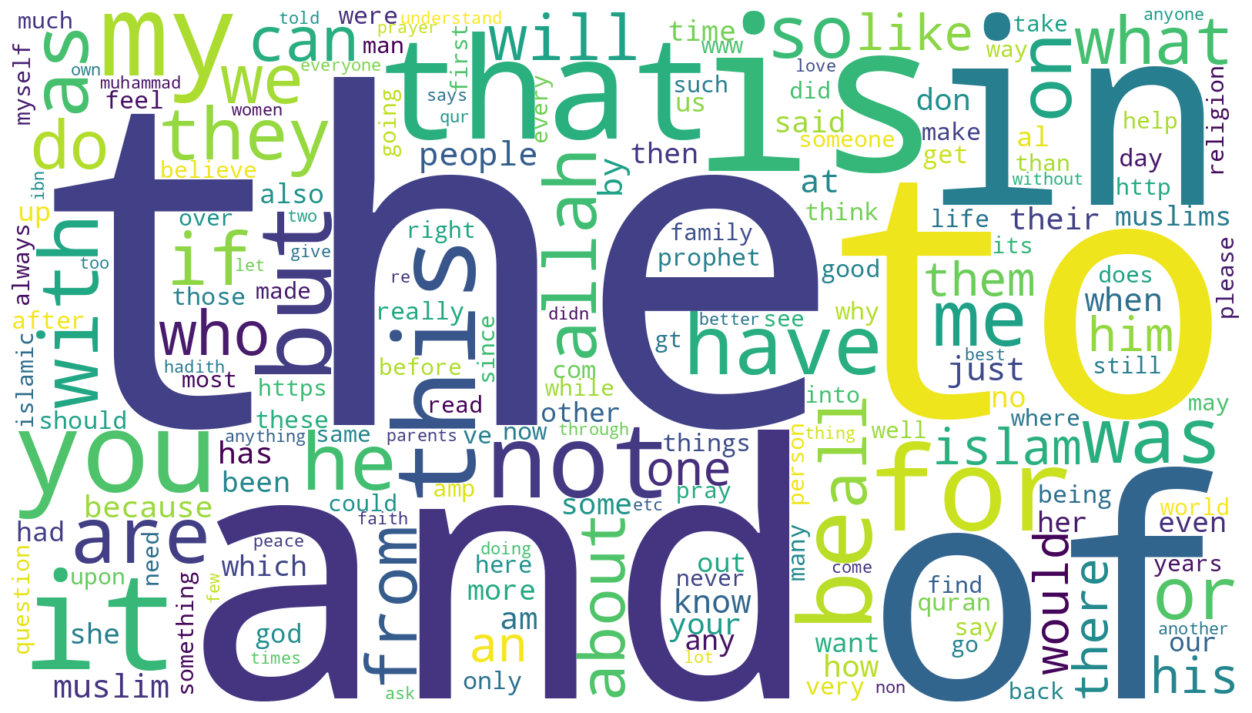

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary from the DataFrame where the terms are keys and Freq Sum are values
word_freq_dict = dict(zip(sumdf['Term'], sumdf['Freq Sum']))

# Set the slide dimensions for a 16:9 aspect ratio slide
slide_width = 16
slide_height =  9

# Create a WordCloud object with the specified dimensions
wordcloud = WordCloud(width=int(slide_width * 100), height=int(slide_height * 100), background_color='white').generate_from_frequencies(word_freq_dict)

# Display the word cloud using matplotlib
plt.figure(figsize=(slide_width, slide_height))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.show()

## Words to be replaced

In [ ]:
contractions = {
    r"ain't": "am not",
    r"aren't": "are not",
    r"can't": "cannot",
    r"could've": "could have",
    r"couldn't": "could not",
    r"didn't": "did not",
    r"doesn't": "does not",
    r"don't": "do not",
    r"hadn't": "had not",
    r"hasn't": "has not",
    r"haven't": "have not",
    r"he'd": "he would",
    r"he'll": "he will",
    r"he's": "he is",
    r"how'd": "how did",
    r"how'll": "how will",
    r"how's": "how is",
    r"i'd": "I would",
    r"i'll": "I will",
    r"i'm": "I am",
    r"i've": "I have",
    r"isn't": "is not",
    r"it'd": "it would",
    r"it'll": "it will",
    r"it's": "it is",
    r"let's": "let us",
    r"mightn't": "might not",
    r"mustn't": "must not",
    r"shan't": "shall not",
    r"she'd": "she would",
    r"she'll": "she will",
    r"she's": "she is",
    r"should've": "should have",
    r"shouldn't": "should not",
    r"that's": "that is",
    r"that'd": "that would",
    r"there's": "there is",
    r"they'd": "they would",
    r"they'll": "they will",
    r"they're": "they are",
    r"they've": "they have",
    r"wasn't": "was not",
    r"we'd": "we would",
    r"we'll": "we will",
    r"we're": "we are",
    r"we've": "we have",
    r"weren't": "were not",
    r"what'll": "what will",
    r"what're": "what are",
    r"what's": "what is",
    r"what've": "what have",
    r"where's": "where is",
    r"who'd": "who would",
    r"who'll": "who will",
    r"who're": "who are",
    r"who's": "who is",
    r"who've": "who have",
    r"won't": "will not",
    r"would've": "would have",
    r"wouldn't": "would not",
    r"you'd": "you would",
    r"you'll": "you will",
    r"you're": "you are",
    r"you've": "you have"
}

quran_spellings = [
    r'qur-an/qur-an-guidan',
    r'qurahn',
    r'qurin',
    r'quraan',
    r'qur’ān',
    r'qurnayn',
    r'qur’an/sunn',
    r'qurân',
    r'qur’aan',
    r'qurʾan',
    r'qurâ€™an',
    r'qurän',
    r'qur;an',
    r'qurʻán',
    r'quruan',
    r'qurʼān',
    r'qur-an',
    r'qurr-on',
    r'qur?an',
    r'quraaniyyoon',
    r'qurran',
    r'qur1an',
    r'quraun',
    r'quraniyyun',
    r'qurýan',
    r'quraaan',
    r'quraaniyoon',
    r'qurʼan',
    r'qur‘ān',
    r'qur`ân',
    r'qur`an',
    r'qurann',
    r'qur`ān',
    r'qurān',
    r'qur’aniyyoon',
    r'qur\x01an',
    r'qur%27an',
    r'quràan',
    r'qura’n',
    r'qur´an',
    r'quranen',
    r'qur‘an',
    r'qur’an',
    r'qurani/quran',
    r'quranan',
    r'quraniyoon',
    r'quran(an',
    r'quran/kuran',
    r'qurʾān',
    r'qur"an',
    r'quraydhan',
    r'quran-an',
    r'quran_an',
    r'qur\\`an'
]

for spelling in quran_spellings:
    contractions[spelling] = "quran"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##Function to clean each document in corpus

In [ ]:
def clean(doc):
    # Make all letters lowercase
    doc=doc.lower()

    # Remove URLs and emails
    doc = re.sub(r'\S*://\S*', ' ' , doc)
    doc = re.sub(r'www\.\S*', ' ' , doc)
    doc = re.sub(r'\S*\.com\S*', ' ' , doc)
    doc = re.sub(r'\S*\.gov\S*', ' ' , doc)
    doc = re.sub(r'\S*\.org\S*', ' ' , doc)
    doc = re.sub(r'\S*\.net\S*', ' ' , doc)
    doc = re.sub(r'\S*\.co\.\S*', ' ' , doc)
    doc = re.sub(r'\S*\.lib\.\S*', ' ' , doc)
    doc = re.sub(r'\S*@\S*', ' ' , doc)

    # Remove the s from possessive nouns
    doc = re.sub(r'\S+\'s', '', doc)

    # expand contractions and also normalise the spelling of quran
    # also adds a space before and after the replaced word
    pattern = r'(' + '|'.join(re.escape(contraction) for contraction in contractions.keys()) + r')'
    doc = re.sub(pattern, lambda x: ' ' + contractions[x.group()] + ' ', doc)

    #Might be useful to normalise the arabic words with apostrophes, it MUST be ran after fixing contractions
    doc = re.sub(r'\'', '', doc)

    # replace every punctuation mark, special character, whitespace character and digit with a space
    doc = re.sub(r'[^a-zA-Z]', ' ', doc)

    doc = nlp(doc)
    # remove stopwords and lemmatize the tokens
    filtered_tokens = [token.lemma_ for token in doc if not token.is_stop]
    # join the filtered tokens back into a document/string
    filtered_document = ' '.join(filtered_tokens)
    # # remove single/double lettered words
    filtered_document = re.sub(r'\b\w{1,2}\b', '', filtered_document)
    # remove any excess whitespace
    filtered_document = re.sub(r'\s+', ' ', filtered_document).strip()
    return filtered_document

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Parallel processing cleaned it in 37min

import copy, multiprocessing
df2 = copy.deepcopy(df)
with multiprocessing.Pool(processes=2) as pool:
    df2['document'] = pool.map(clean, df['document'])

df2.replace('', np.nan, inplace=True)
df2 = df2.dropna().reset_index(drop=True)

# Save the cleaned dataset
df2.to_csv("reddit-islam-cleaned-v2.csv", index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
##### Serial processing method

# # Apply the clean function on every document
# df['document'] = df['document'].apply(clean)
# df = df.dropna().reset_index(drop=True)

# # Save the cleaned dataset
# df.to_csv("Reddit-Islam-clean.csv", index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Data Exploration

##This will be used to create a document-term matrix from the dataset of reviews(documents)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def doc_term_matrix(df):
    cv = CountVectorizer()

    # Form a document term matrix using the document column of df
    # dtm is a sparse matrix containing elements in the form: (row,col)->frequency
    dtm = cv.fit_transform(df['document'])

    # Print some info about our document-term matrix
    print("Total no. of documents:",dtm.shape[0])
    print("\nSize of the vocabulary:",dtm.shape[1],"\n")
    return cv,dtm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Reading the CSV

In [ ]:
'''
Sort the terms by the sum of their frequencies across the corpus

For topic modeling, it's recommended to use the sum instead of mean.
Since the mean may result in high values for terms common across many documents
and thus not help distinguish topics.
The sum may give high values to terms that are only common in some documents and
thus help distinguish topics.
'''
df_clean = pd.read_csv("/content/drive/MyDrive/FYP/Data/Reddit-Islam-raw.csv")
cv_clean,dtm_clean = doc_term_matrix(df_clean)

# This is a list of the sum of freqs
sums = dtm_clean.sum(axis=0).tolist()[0]
# This is a list of the corresponding terms
terms = cv_clean.get_feature_names_out().tolist()
# Create a dataframe of terms and their frequency sum then sort it by the sum
sumdf = pd.DataFrame({'Term': terms, 'Freq Sum': sums})
sumdf.sort_values(by='Freq Sum', ascending=False, inplace=True)
sumdf.head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total no. of documents: 39998

Size of the vocabulary: 126828 



Term  Freq Sum
100398   the    436306
16995    and    337651
101721    to    319616
74371     of    244034
53718     in    164860
56002     is    164451
100343  that    154540
56745     it    138824
43769    for    101787
71033     my    100407
111317   you     95840
101044  this     93986
73412    not     78409
22572     be     75051
25875    but     74450
49191   have     73617
109588  with     69306
18788     as     68099
49386     he     66935
66472     me     66448

## Bigrams

In [ ]:
# Example for detecting bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()

tokenized_data = df_clean['document'].apply(lambda x: simple_preprocess(x))
finder = nltk.collocations.BigramCollocationFinder.from_documents(tokenized_data)

# Filter only those that occur at least 50 times
finder.apply_freq_filter(100)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
finder.ngram_fd.items()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


dict_items([(('existence', 'god'), 144), (('relate', 'islam'), 116), (('islam', 'quran'), 242), (('god', 'exist'), 278), (('god', 'islam'), 116), (('belief', 'god'), 153), (('lack', 'knowledge'), 127), (('islamic', 'belief'), 100), (('belief', 'islam'), 159), (('islam', 'muslim'), 759), (('quran', 'god'), 144), (('quran', 'quran'), 246), (('word', 'god'), 423), (('true', 'god'), 169), (('holy', 'book'), 222), (('prophet', 'muhammad'), 1914), (('muhammad', 'pbuh'), 770), (('islamic', 'scholar'), 217), (('answer', 'question'), 1146), (('read', 'quran'), 2411), (('quran', 'word'), 195), (('quran', 'allah'), 370), (('accept', 'islam'), 382), (('faith', 'islam'), 182), (('islam', 'true'), 258), (('point', 'view'), 351), (('believe', 'quran'), 210), (('islam', 'allah'), 273), (('turn', 'away'), 460), (('worldly', 'life'), 186), (('allah', 'guide'), 582), (('create', 'heaven'), 100), (('heaven', 'earth'), 339), (('night', 'day'), 192), (('day', 'night'), 271), (('sun', 'moon'), 117), (('allah

In [ ]:
bigramFreqTable = pd.DataFrame(list(finder.ngram_fd.items()), columns=['bigram','freq']).sort_values(by='freq', ascending=False)
bigramFreqTable

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


bigram  freq
171             (allah, swt)  4538
603        (brother, sister)  4270
19             (read, quran)  2411
57        (messenger, allah)  2350
15       (prophet, muhammad)  1914
...                      ...   ...
1093  (jazakallahu, khairan)   100
592          (answer, allah)   100
930          (sunni, muslim)   100
489            (golden, age)   100
144            (book, write)   100

[1145 rows x 2 columns]

In [ ]:
# Example filter for noun-type structures bigrams
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

# Can eyeball list and choose PMI threshold where n-grams stop making sense
# In this case, get top 500 bigrams/trigrams with highest PMI score
filtered_bigram = bigramFreqTable[bigramFreqTable.apply(lambda bigram: bigram_filter(bigram['bigram']) and bigram.freq > 5, axis = 1)][:500]
bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
bigrams

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['allah swt',
 'brother sister',
 'read quran',
 'messenger allah',
 'prophet muhammad',
 'peace blessing',
 'prophet pbuh',
 'time day',
 'answer question',
 'allah allah',
 'wear hijab',
 'muslim community',
 'convert islam',
 'long time',
 'believe god',
 'muslim country',
 'pray time',
 'muslim muslim',
 'prophet peace',
 'man woman',
 'thank advance',
 'muslim woman',
 'sahih bukhari',
 'prophet sallallahu',
 'sallallahu alaihi',
 'alaihi wasallam',
 'believe allah',
 'learn islam',
 'middle east',
 'allah bless',
 'muhammad pbuh',
 'islam muslim',
 'assalamu alaikum',
 'wan na',
 'muslim man',
 'book hadith',
 'abu bakr',
 'allah peace',
 'holy prophet',
 'muslim world',
 'islam religion',
 'high school',
 'live life',
 'muslim family',
 'spend time',
 'holy quran',
 'bear muslim',
 'worship allah',
 'family member',
 'day judgement',
 'quran hadith',
 'fast day',
 'day day',
 'saudi arabia',
 'verse quran',
 'pray allah',
 'allah messenger',
 'commit sin',
 'blessing allah',
 't

## Further cleaning
I sorted the terms by their total frequency in the corpus and analyzed the words at the top of the list to determine if they helped to distinguish topics.  
I found several words that were common in all the reviews, such as 'movie', 'film', 'like', 'good', 'bad', 'great', 'way', that did not help to distinguish topics.  
As a result, I defined these terms in the set "custom_stopwords"
and removed these from the corpus

In [ ]:
# pd.options.display.max_rows = 100
# possible_stopwords=sumdf[(sumdf['Term'].str.len()<=4) & (sumdf['Term'].str.len()>2)]
# possible_stopwords.to_csv("possible-stopwords.csv", index=True)

In [ ]:
custom_stopwords = {"feel", "come", "thing", "think", "want", "don", "like",
                    "know", "good", "feel", "ask", "com", "say", "way",
                    "find", "tell", "year", "help", "try", "amp", "gt", "https", "look",
                    "jippe", "jireen", "jirfvfe", "jiveprinte", "jjfsdmhxzbf", "jjdhf",
                    "zzz", "see", "www", "get", "http", "comment", "nbsp", "net", "pdf",
                    "org", "post", "app", "link", "jitxi", "watch", "zzzcb", "thc", "edu",
                    "people", "non", "render", "use", "itune", "detail", "bring", "store",
                    "etc", "let", "wiki", "wikipedia", "didn", "give",
                    "lot", "let", "not", "sure", "png", "audio", "thy",
                    "jpg", "webp", "kjv", "ksu", "series", "unto", "cuz",
                    "laa", "happen", "TRUE", "ago", "yes", "soon", "till", "got", "actually",
                    "html", "hey", "php", "thou", "preview", "lil", "doesn", "have", "anymore",
                    "reddit", "video", "youtube", "amazon", "islamqa", "facebook", "youtuber",
                    "episode", "youtu", "redd", "imgur", "islamawakene", "islamawakened",
                    "medium", "discord", "thread", "twitter", "podcast", "subreddit", "edit",
                    "server", "pjpg", "afaik", "idk", "org", "sub", "purposely", "utm",
                    "zoom", "sim", "thee", "mod", "respectively", "podbean", "utf", "xkuh",
                    "wordpress", "lest", "htm", "user", "gets", "yeah", "lol", "yah"
                    "mean", "take", "need", "make", "consider", "ugh"}

def remove_custom_stopwords(document, custom_stopwords):
    tokens = word_tokenize(document)
    filtered_tokens = [t for t in tokens if t not in custom_stopwords]
    filtered_document = ' '.join(filtered_tokens)
    return filtered_document

df_clean['document'] = df_clean['document'].apply(remove_custom_stopwords, custom_stopwords=custom_stopwords)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


I sorted the terms again by their total frequency in the corpus and we can see that the words at the top of the list are now more helpful to distinguish topics.

In [ ]:
cv_clean,dtm_clean = doc_term_matrix(df_clean)

# This is a list of the sum of freqs
sums = dtm_clean.sum(axis=0).tolist()[0]
# This is a list of the corresponding terms
terms = cv_clean.get_feature_names_out().tolist()
# Create a dataframe of terms and their frequency sum then sort it by the sum
sumdf = pd.DataFrame({'Term': terms, 'Freq Sum': sums})
sumdf.sort_values(by='Freq Sum', ascending=False, inplace=True)
sumdf.tail(30)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total no. of documents: 39978

Size of the vocabulary: 70370 



Term  Freq Sum
37958        marzuban         1
37943        marwiyat         1
37963        masaabeh         1
37964        masaabih         1
37965        masaacre         1
37967         masaail         1
7542          baradar         1
37970        masaalik         1
7541            barad         1
7550         barakaat         1
37942      marwaziyya         1
37911         martini         1
37923           marur         1
37912          martry         1
37913         martrye         1
7558         barakahu         1
37917  martyrological         1
37918         martyrs         1
37920       marujuana         1
37922           marum         1
37924       marusthal         1
37939        marwanid         1
7556        barakahtu         1
37926          marvan         1
7554       barakacity         1
37931          marvia         1
37934         marwaan         1
37935         marwadh         1
37938         marwani         1
0                 aaa         1

In [ ]:
# Use for locating certain terms and their freqs
sumdf.loc[sumdf['Term'] == 'ayn']

We observed that, the top ???? most frequent terms account for a significant portion of the total word frequency.  
Therefore, to improve the quality and efficiency of topic modeling, we will only consider terms that have a total frequency greater than 100, as they are more likely to be meaningful and informative.

In [ ]:
pd.options.display.max_rows = 1000
sumdf[7000:8000]

In [ ]:
# Use for reducing documents (for speed purposes)
half_of_rows = df_clean.sample(n=20000)

# The remaining half of the rows
df_clean = df_clean.drop(half_of_rows.index)
len(df_clean["document"])

#Topic Modeling

##**LDA (Latent Dirichlet Allocation)**  
We can assume that a **document** consists of a probability distribution **(a mix) of topics** and a **topic** consists of a probability distribution **(a mix) of terms.** We want LDA to learn these probability distributions.

LDA requires a term-document matrix, the no. of topics and the no. of iterations to perform.

*   First LDA starts by randomly assigning a topic to each word in each document.
*   Then it goes through all of the words again and judges if the topic for a word needs to be changed.  
* It repeats the above step for the no. of iterations it was told to perform.
* The user then looks at the distributions to judge if the topics discovered look accurate and distinct and they may name these topics.

*For example, initially word X was assigned topic A in document 1.*

LDA evaluates if the topic for that word needs to be reassigned using 2 criteria:
1.   Does topic A infrequently occur in document 1?
2.   Does word X infrequently occur in topic A across all documents?




---
##Using scikit-learn for LDA

In [ ]:
from gensim.models import CoherenceModel
import gensim.corpora as corpora

def get_Cv(model, df_columnm):
  topics = model.components_

  n_top_words = 20
  texts = [[word for word in doc.split()] for doc in df_columnm]

  # create the dictionary
  dictionary = corpora.Dictionary(texts)
  # Create a gensim dictionary from the word count matrix

  # Create a gensim corpus from the word count matrix
  corpus = [dictionary.doc2bow(text) for text in texts]

  feature_names = [dictionary[i] for i in range(len(dictionary))]

  # Get the top words for each topic from the components_ attribute
  top_words = []
  for topic in topics:
      top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

  coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
  coherence = coherence_model.get_coherence()
  return coherence

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
#max_df means that if any term appears in more than 95% of the documents then it will be excluded
#min_df means that if any term appears in less than 5 documents then it will be excluded
vec = CountVectorizer(max_df=0.95, min_df=5, max_features=8000)
dtm = vec.fit_transform(df_clean['document'])
feature_names = vec.get_feature_names_out()

# n_components is the no. of topics
# learning_method is the method for updating the topic probabilities during each iteration
# "online" learning method allows for faster and more memory-efficient training
# learning_offset downweights early iterations and helps the model converge faster
# random_state ensures reproducibility of the results, essential for experimenting
lda = LatentDirichletAllocation(n_components=34, max_iter=50, learning_method='online', learning_offset=50.,random_state=0).fit(dtm)

#how many of the top words for each topic to print
no_top_words = 10
for topic_no, topic in enumerate(lda.components_):
        print("Topic", topic_no+1, ":")
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        print(" ".join(top_words))

### Visualization of LDA Models with pyLDAvis

In [ ]:
# 34 topics, 20 iterations
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda, dtm, vec)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.211629  0.104207       1        1  14.780785
20    -0.204134 -0.095004       2        1   8.277540
3     -0.221319 -0.124932       3        1   6.918977
26     0.041452  0.110240       4        1   6.137531
32    -0.155404  0.123449       5        1   5.905146
4     -0.175193 -0.044220       6        1   4.566869
6     -0.089407 -0.160586       7        1   3.877272
24    -0.127232 -0.086899       8        1   3.719505
11    -0.082804 -0.088519       9        1   3.295772
2     -0.086329  0.038991      10        1   3.262709
12     0.228398  0.039877      11        1   3.067411
18     0.058916  0.199382      12        1   2.772808
0     -0.040837 -0.020453      13        1   2.764949
14    -0.049801  0.158672      14        1   2.618740
30    -0.091492  0.140116      15        1   2.292833
8     -0.002102 -0.177716      16        1   2.198805
33     0.135947  0.019955      17        1   1.947527
21     0.001518 -0.013003      18        1   1.803667
10     0.036908 -0.200202      19        1   1.801404
5     -0.054288  0.155919      20        1   1.777354
9     -0.079119  0.060402      21        1   1.764478
19     0.172055  0.024382      22        1   1.609972
1     -0.039795  0.180395      23        1   1.578576
29     0.070147  0.066443      24        1   1.521910
7      0.151972 -0.134567      25        1   1.455992
22     0.143951 -0.006208      26        1   1.446109
31    -0.038165 -0.159330      27        1   1.323007
17     0.033912 -0.061294      28        1   1.321335
16     0.080834  0.041959      29        1   0.853914
23     0.115482 -0.110521      30        1   0.849967
25     0.106829  0.180584      31        1   0.747591
28     0.115082 -0.025307      32        1   0.614975
27     0.036389 -0.041675      33        1   0.586525
13     0.219261 -0.094540      34        1   0.538044, topic_info=          Term          Freq         Total Category  logprob  loglift
364      allah  53555.000000  53555.000000  Default  30.0000  30.0000
7122     quran  16185.000000  16185.000000  Default  29.0000  29.0000
6944   prophet  18927.000000  18927.000000  Default  28.0000  28.0000
4716     islam  37050.000000  37050.000000  Default  27.0000  27.0000
3681       god  18588.000000  18588.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
5849  muhammad    244.809046   6845.884390  Topic34  -4.3666   1.8941
1186      book    227.787279   8384.765146  Topic34  -4.4387   1.6192
7826     saudi    141.583547   1241.906326  Topic34  -4.9142   3.0535
1362      call    122.472183   4652.304811  Topic34  -5.0592   1.5878
5599   mention    120.734178   4960.402493  Topic34  -5.0735   1.5093

[2337 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0        27  0.977464      aad
7        29  0.993468      aan
8        22  0.988212    aaron
14       26  0.975037      aba
16       25  0.980059     aban
...     ...       ...      ...
9981      5  0.056580     zina
9981     10  0.772858     zina
9983     18  0.995108  zionist
9988     33  0.985170     zoom
9995     12  0.994101     zuhr

[7524 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 21, 4, 27, 33, 5, 7, 25, 12, 3, 13, 19, 1, 15, 31, 9, 34, 22, 11, 6, 10, 20, 2, 30, 8, 23, 32, 18, 17, 24, 26, 29, 28, 14])

### Saving LDA Model

In [ ]:
from pprint import pprint

def export_lda_top_words(lda_model, num_words=15):
    # Initialize an empty DataFrame to store the top words for each topic
    data = []

    # Iterate through each topic in the LDA model
    for topic_no, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-15 - 1:-1]]

        # Add the top words to the DataFrame with a column name indicating the topic
        data.append((f"Topic {topic_no + 1}", ", ".join(top_words)))

    # Save the DataFrame to a CSV file
    top_words_df = pd.DataFrame(data, columns=["topic", "words"])
    top_words_df.to_csv(f"lda_topics_{len(lda.components_)}.csv", index=False)

In [ ]:
#labels = ["label_{}".format(i) for i in range(dtm.shape[1])]
# result_dict = {}
# for row_index, row in enumerate(dtm[0]):
#     result_dict[row_index] = {label: row[0, col_index] for col_index, label in enumerate(labels)}
#     print(result_dict)

export_lda_top_words(lda)

In [ ]:
export_lda_top_words(lda)

###2nd Attempt:
To improve the quality of the generated topics, we will extract the nouns and adjectives from the corpus.

Extracting parts of speech, specifically nouns and adjectives, can be helpful for topic modeling because they often carry important semantic information about the topics being discussed in the text.  
By focusing on these parts of speech, we can potentially improve the coherence and interpretability of our topic models, as they are likely to capture the most salient features of the text.

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def extract_parts_of_speech(document):
    doc = nlp(document)
    filtered_tokens = [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ']]
    filtered_document = ' '.join(filtered_tokens)
    return filtered_document

df_pos = df_clean.copy()
df_pos['document']=df_pos['document'].apply(extract_parts_of_speech)
df_pos.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


document
0  curious figure rational interested philosophic...
1  myth proportion islamic terrorist attack soil ...
2  concept slavery topic slavery woman topic defa...
3  internal persecution outside violence practice...
4  man search cause universe right sub automic pa...
5  leather tent count sign approach hour death co...
6  response original praise allaah praise forgive...
7  exposure death experience nde conference relig...
8  deed minute prophet reward day gathering proph...
9  issue sale chess wood wind instrument lute law...

In [ ]:
vec_pos = CountVectorizer(max_df=0.95, min_df=5, max_features=10000)
dtm_pos = vec_pos.fit_transform(df_pos['document'])
feature_names_pos = vec_pos.get_feature_names_out()
lda_pos = LatentDirichletAllocation(n_components=34, max_iter=20, learning_method='online', learning_offset=50.,random_state=0).fit(dtm_pos)

no_top_words = 10
for topic_no, topic in enumerate(lda_pos.components_):
        print("Topic", topic_no+1, ":")
        top_words = [feature_names_pos[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        print(" ".join(top_words))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 1 :
human animal body soul dog test tree life angel disease
Topic 2 :
woman man female male wife gender husband right girl cover
Topic 3 :
life time bad day problem person point health pray pain
Topic 4 :
prayer sin time pray day deed reward prophet forgiveness praise
Topic 5 :
question religion answer guy time thank friend faith talk person
Topic 6 :
day fast food month meat drink pork eat time hour
Topic 7 :
heart love life action path knowledge great mercy world word
Topic 8 :
money music pay interest job work halal loan business company
Topic 9 :
earth verse sign sky day time sun miracle format mountain
Topic 10 :
scholar opinion knowledge source issue study question student islamic topic
Topic 11 :
mother family brother wife sister man father husband son home
Topic 12 :
water hand head body foot hair wudu face clean wash
Topic 13 :
attack terrorist death news crime article police violence murder innocent
Topic 14 :
child old marriage age parent young kid boy girl baby
Topic 

Some of the topics that can be interpreted from above may be:  
Topic 1: Entertainment media  
Topic 2: Acting and filmmaking  
Topic 3: Life and society  
Topic 4: War and history  
Topic 5: Musicals  
Topic 6: Highschool dramas with crime  
Topic 7: Romantic and family movies  
Topic 8: Horror movies  
Topic 9: Criticism of comedy movies  
Topic 10: Violent action movies  

---
The visualisation below shows that using the nouns and adjectives may have worked better since the circles representing the topics are overlapping even less than the previous attempt.

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda_pos, dtm_pos, vec_pos)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4     -0.237044  0.044354       1        1  9.803262
30    -0.190593 -0.097647       2        1  9.361426
2     -0.184330 -0.126949       3        1  8.787600
6     -0.127678 -0.030044       4        1  5.796394
16    -0.178630  0.186328       5        1  5.413138
29    -0.111123 -0.161067       6        1  4.272584
24    -0.107197  0.120407       7        1  3.985460
21    -0.038964 -0.063558       8        1  3.873431
20    -0.007880 -0.156056       9        1  3.716062
19    -0.103083  0.079067      10        1  3.362773
3     -0.034933 -0.207997      11        1  3.023434
26    -0.082437  0.160490      12        1  2.952378
9     -0.136026  0.182397      13        1  2.932593
10    -0.007452 -0.146595      14        1  2.899677
32    -0.090593  0.117619      15        1  2.707400
22    -0.080640  0.100591      16        1  2.492085
12     0.060820  0.065211      17        1  2.090496
7     -0.014230  0.045518      18        1  2.042263
11     0.097418 -0.134601      19        1  1.924236
1      0.052627  0.067276      20        1  1.923591
27    -0.021407  0.054728      21        1  1.862636
5      0.007143 -0.170232      22        1  1.777327
18     0.071854  0.009671      23        1  1.579316
0      0.055903  0.010878      24        1  1.533154
13     0.086823 -0.028183      25        1  1.461265
17     0.032588 -0.206433      26        1  1.439396
8      0.015083 -0.037231      27        1  1.369446
25     0.139224 -0.024671      28        1  1.238609
33     0.104659  0.050348      29        1  1.152744
15     0.098677  0.057089      30        1  0.911364
23     0.210025  0.058606      31        1  0.867342
28     0.247428  0.062384      32        1  0.578264
14     0.240602  0.014946      33        1  0.479876
31     0.233364  0.103355      34        1  0.388978, topic_info=         Term          Freq         Total Category  logprob  loglift
6937  prophet  15186.000000  15186.000000  Default  30.0000  30.0000
9885    woman  10370.000000  10370.000000  Default  29.0000  29.0000
2206      day  17888.000000  17888.000000  Default  28.0000  28.0000
6752   prayer  10844.000000  10844.000000  Default  27.0000  27.0000
5406      man  12074.000000  12074.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
4261     host     38.522477    286.985008  Topic34  -5.3429   3.5412
5920     name     49.426951   1236.930066  Topic34  -5.0937   2.3295
7868  section     38.214299    845.501655  Topic34  -5.3510   2.4527
6186   online     31.008416   1147.023204  Topic34  -5.5599   1.9387
9543   useful     28.558706    376.555702  Topic34  -5.6422   2.9703

[2263 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
31        1  0.139533      able
31        2  0.190998      able
31        3  0.123561      able
31        4  0.083853      able
31        5  0.008873      able
...     ...       ...       ...
9971     26  0.982827  youtuber
9974      3  0.975844    zabiha
9979     18  0.993199     zakat
9981      8  0.960964    zaynab
9993     27  0.978292      zoom

[6344 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 31, 3, 7, 17, 30, 25, 22, 21, 20, 4, 27, 10, 11, 33, 23, 13, 8, 12, 2, 28, 6, 19, 1, 14, 18, 9, 26, 34, 16, 24, 29, 15, 32])

## Using Gensim for LDA


### Preparing the Gensim Corpus

Tokenizing the Data first, because gensim requires a list of tokens (strings), and preparing it in the "Corpus" and "Dictionary" format which all gensim-models use.

In [ ]:

tokenized_data = df_clean['document'].apply(lambda x: simple_preprocess(x))

dictionary = Dictionary(tokenized_data)
print("Before removing extremes", len(dictionary))
dictionary.filter_extremes(no_below = 5, no_above = 0.50)
print("After removing extremes", len(dictionary))

corpus = [dictionary.doc2bow(doc) for doc in tokenized_data]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Before removing extremes 112882
After removing extremes 112882


### Creating a LDA Model

In [ ]:
# Setting random_state to 0 for reproducibility
# ldamodel = LdaModel(corpus=corpus, num_topics=7, id2word=dictionary, iterations=50, offset=50., random_state = 0)
ldamodel = LdaModel(corpus=corpus, id2word=dictionary, num_topics=80, chunksize=2000, passes=10, iterations=20, alpha='auto', eta='auto', random_state=0)
ldamodel.show_topics()

In [ ]:
coherence_model = CoherenceModel(model=ldamodel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence_model.get_coherence()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-4.532091514808313

In [ ]:
coherence_model = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=tokenized_data, coherence='c_v')
coherence_model.get_coherence()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.5512647967640628

### Gensim LDA Coherence Testing

In [ ]:
from gensim.models import CoherenceModel

for i in range(43, 61, 1):
    # Setting random_state to 0 for reproducibility
    # ldamodel = LdaModel(corpus=corpus, num_topics=7, id2word=dictionary, iterations=50, offset=50., random_state = 0)
    ldamodel = LdaModel(corpus=corpus, id2word=dictionary, num_topics=i, chunksize=2000, passes=10, iterations=20, alpha='auto', eta='auto', random_state=0)
    coherence_model = CoherenceModel(model=ldamodel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    print(f"Topic {i}")
    print("Umass:", coherence_model.get_coherence())
    coherence_model = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=tokenized_data, coherence='c_v')
    print("Coherence:", coherence_model.get_coherence(), "\n")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic 41
Umass: -4.24052373494538
Coherence: 0.4503124109527824 

Topic 42
Umass: -5.051854636910996
Coherence: 0.4262263058631567 

Topic 43
Umass: -3.9698141005072713
Coherence: 0.4400994247113731 

Topic 44
Umass: -4.626150699399951
Coherence: 0.4438535587835139 

Topic 45
Umass: -5.197105745879177
Coherence: 0.4322562582040103 

Topic 46
Umass: -4.9064916833013
Coherence: 0.4542065624263123 

Topic 47
Umass: -4.806263567053277
Coherence: 0.458533632120059 

Topic 48
Umass: -5.097534779379325
Coherence: 0.4472917410080852 

Topic 49
Umass: -5.728938036039975
Coherence: 0.44346834637473936 

Topic 50
Umass: -6.145634385734349
Coherence: 0.45136464858127445 

Topic 51
Umass: -5.9869263511805215
Coherence: 0.4269669478334743 

Topic 52
Umass: -5.802500152282436
Coherence: 0.44126788862689437 

Topic 53
Umass: -4.975554432474347
Coherence: 0.4337551567104602 

Topic 54
Umass: -6.185972503047826


### Visualizing the LDA Results using pyLDAvis


In [ ]:
from pyLDAvis import gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
34     0.277526 -0.105612       1        1  14.030932
26     0.246357 -0.033427       2        1   9.149694
55     0.198067 -0.042035       3        1   4.500796
0      0.118150 -0.077907       4        1   4.052262
14     0.139028 -0.152263       5        1   3.526118
22     0.168892 -0.123723       6        1   3.076073
48     0.142688  0.078456       7        1   3.025256
4      0.089072  0.234439       8        1   2.681247
27     0.150913 -0.084753       9        1   2.676222
40     0.081270  0.244078      10        1   2.534522
2      0.135688 -0.096925      11        1   2.414695
17     0.146320 -0.049713      12        1   2.392931
45     0.140408 -0.004461      13        1   2.370500
25     0.117429 -0.006828      14        1   2.289472
6      0.050632  0.284223      15        1   2.130380
50     0.102626 -0.153310      16        1   1.975546
16     0.103593 -0.031790      17        1   1.922752
18     0.082760 -0.007360      18        1   1.851304
49     0.118904 -0.013827      19        1   1.820888
12     0.082982 -0.000245      20        1   1.736152
7      0.071098  0.196058      21        1   1.676085
57     0.050030 -0.047765      22        1   1.604765
59     0.068673  0.063860      23        1   1.598574
41     0.036048 -0.041375      24        1   1.554072
46     0.077952  0.003363      25        1   1.546093
54    -0.021932 -0.043715      26        1   1.532531
28     0.030572 -0.029854      27        1   1.498802
8     -0.002918  0.156323      28        1   1.383461
58     0.062113  0.093420      29        1   1.327841
52     0.073555 -0.079265      30        1   1.262944
20     0.016582 -0.090431      31        1   1.139517
37    -0.070563  0.129972      32        1   1.072250
44     0.020856  0.242335      33        1   1.017575
53    -0.024202  0.082201      34        1   0.862792
51    -0.063119  0.195353      35        1   0.861970
31    -0.080678 -0.057479      36        1   0.834108
43    -0.002044 -0.064407      37        1   0.824973
15     0.024781 -0.030175      38        1   0.691520
56    -0.067398 -0.006415      39        1   0.612398
5     -0.091770 -0.006394      40        1   0.602170
10    -0.100943  0.002232      41        1   0.582769
32    -0.057495  0.055506      42        1   0.564019
23    -0.118660  0.005151      43        1   0.488344
13    -0.123635 -0.035700      44        1   0.419438
1     -0.139775 -0.037655      45        1   0.416028
38    -0.108954 -0.007575      46        1   0.371867
19    -0.111277 -0.033568      47        1   0.368812
24    -0.124156 -0.024438      48        1   0.365241
21    -0.139392 -0.035776      49        1   0.324182
33    -0.097353 -0.011950      50        1   0.323187
11    -0.147767 -0.022068      51        1   0.315180
29    -0.139252 -0.040172      52        1   0.303038
39    -0.148153 -0.023327      53        1   0.279207
36    -0.167340 -0.039010      54        1   0.261144
35    -0.154241 -0.048005      55        1   0.211673
30    -0.172906 -0.044394      56        1   0.203263
42    -0.183649 -0.045398      57        1   0.150241
9     -0.188756 -0.042152      58        1   0.148651
47    -0.185014 -0.045727      59        1   0.128122
3     -0.192221 -0.048600      60        1   0.113411, topic_info=           Term          Freq         Total Category  logprob  loglift
36        allah  50288.000000  50288.000000  Default  30.0000  30.0000
460      muslim  48819.000000  48819.000000  Default  29.0000  29.0000
318         god  18090.000000  18090.000000  Default  28.0000  28.0000
551     prophet  18567.000000  18567.000000  Default  27.0000  27.0000
562       quran  23373.000000  23373.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
13003      akhi     27.123853     29.271386  Topic60  -4.9938   6.7057
4909     swerve     24.483861     26.6313

In [ ]:
from pyLDAvis import gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
34     0.287394 -0.087844       1        1  15.104223
26     0.246183 -0.145064       2        1   9.220922
14     0.134452 -0.072540       3        1   3.440433
67     0.158643  0.167963       4        1   2.766461
27     0.166651  0.040336       5        1   2.722045
...         ...       ...     ...      ...        ...
39    -0.170622 -0.030032      76        1   0.129188
31    -0.169867 -0.028676      77        1   0.128395
3     -0.169558 -0.029843      78        1   0.119909
63    -0.193551 -0.045546      79        1   0.043333
47    -0.195402 -0.053489      80        1   0.024787

[80 rows x 5 columns], topic_info=               Term          Freq         Total Category  logprob  loglift
36            allah  48638.000000  48638.000000  Default  30.0000  30.0000
460          muslim  49572.000000  49572.000000  Default  29.0000  29.0000
176             day  19444.000000  19444.000000  Default  28.0000  28.0000
318             god  18056.000000  18056.000000  Default  27.0000  27.0000
391           islam  34395.000000  34395.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
15172      polarize      1.783807      3.947497  Topic80  -6.1948   7.5083
138    conclusively      0.021527      2.185217  Topic80 -10.6119   3.6825
157     contingency      0.021527      2.185217  Topic80 -10.6119   3.6825
0              able      0.021527   4416.881099  Topic80 -10.6119  -3.9290
1          absolute      0.021527    480.534585  Topic80 -10.6119  -1.7107

[4311 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
5450      23  0.929765     aali
5451       4  0.948439   aameen
4117      57  0.983748   aayaat
12450     42  0.939067      aba
11729     38  0.977090    abaya
...      ...       ...      ...
7439      12  0.993529  zionist
9242      55  0.930330    ziyad
3701      20  0.980335     zuhd
4668      15  0.987339     zuhr
2091       6  0.980141    zumar

[11326 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[35, 27, 15, 68, 28, 5, 56, 49, 63, 23, 18, 1, 29, 20, 46, 22, 7, 19, 10, 70, 42, 47, 72, 58, 6, 54, 79, 76, 13, 8, 50, 45, 21, 31, 51, 59, 33, 3, 73, 41, 65, 24, 17, 80, 74, 14, 44, 61, 9, 30, 12, 38, 67, 77, 2, 60, 52, 26, 75, 25, 36, 37, 11, 34, 39, 69, 78, 53, 55, 62, 57, 43, 66, 71, 16, 40, 32, 4, 64, 48])

In [ ]:
from pyLDAvis import gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
52    -0.305837 -0.176908       1        1  10.856382
41    -0.302858 -0.128597       2        1  10.097936
74    -0.287726 -0.178722       3        1   7.334595
91    -0.268394 -0.132618       4        1   4.869049
47    -0.261969 -0.220332       5        1   4.378153
...         ...       ...     ...      ...        ...
97     0.231803 -0.035267      96        1   0.038045
95     0.234574 -0.036229      97        1   0.035675
66     0.238623 -0.037248      98        1   0.029369
7      0.238327 -0.037108      99        1   0.025075
27     0.241415 -0.037948     100        1   0.021223

[100 rows x 5 columns], topic_info=            Term          Freq         Total  Category  logprob  loglift
38         allah  54090.000000  54090.000000   Default   30.000  30.0000
185          day  18970.000000  18970.000000   Default   29.000  29.0000
601        quran  17771.000000  17771.000000   Default   28.000  28.0000
417        islam  38459.000000  38459.000000   Default   27.000  27.0000
336          god  20674.000000  20674.000000   Default   26.000  26.0000
..           ...           ...           ...       ...      ...      ...
11       account      0.007014   1778.426509  Topic100  -11.648  -3.9856
12   acknowledge      0.007014    421.176891  Topic100  -11.648  -2.5451
13      acquaint      0.007014     62.836373  Topic100  -11.648  -0.6426
14           act      0.007014   3470.903957  Topic100  -11.648  -4.6542
15        action      0.007014   3140.007762  Topic100  -11.648  -4.5540

[4933 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
15969     95  0.468701     aab
3936      83  0.914276     aad
12448     68  0.905032   aadam
6581       8  0.949138  aameen
5801      38  0.980330     aan
...      ...       ...     ...
26956     90  0.799397     zoo
4274      41  0.985863    zuhd
5467       3  0.979665    zuhr
5467      12  0.010422    zuhr
2391       9  0.987736   zumar

[11270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[53, 42, 75, 92, 48, 21, 90, 26, 62, 39, 59, 58, 95, 36, 30, 54, 60, 69, 73, 5, 85, 25, 71, 6, 86, 43, 78, 15, 80, 3, 52, 40, 46, 1, 27, 37, 84, 47, 66, 7, 99, 56, 38, 87, 17, 35, 88, 4, 50, 51, 81, 22, 29, 74, 12, 45, 16, 13, 33, 19, 32, 82, 2, 93, 49, 64, 10, 11, 18, 57, 44, 23, 65, 97, 94, 61, 63, 83, 70, 100, 79, 14, 55, 89, 34, 9, 77, 76, 24, 20, 72, 31, 41, 68, 91, 98, 96, 67, 8, 28])

## (Optional) Using Bi-grams to detect Phrases

Adding bi_grams into our corpus for detecting better topics. Bigrams check for words which occur together often, like "New" and "York" and then connects them together with an underscore, like "New_York".

This may not always result in better topics though as you can see below where it mostly detects full names and no coherent topics.

NOTE: PERFORMING BIGRAMS AFTER REMOVING STOPWORDS ISNT EXACTLY A GREAT IDEA

In [ ]:
bigram = Phrases(tokenized_data)
tokenized_data = [bigram[line] for line in tokenized_data]

phrases = Phrases(tokenized_data, min_count=3, threshold=7000)

#Finding the created bi_grams with their scores
phrases_scores = sorted(phrases.find_phrases(tokenized_data).items(), key=lambda x: x[1], reverse=True)
for phrase, score in phrases_scores:
    print(phrase, score)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


swedish_agency_psychological_defense 164844.75
fataawa_lajnah_daa_imah 164844.75
ibr_innaka_dun_maj 164844.75
dun_maj_dun 164844.75
hijabis_lurker_participate_verify 164844.75
osman_nuri_topbas 164844.75
ayaat_ring_structure_ayaat 164844.75
excerpt_farhat_hashmi_speech 164844.75
valuation_house_ultimately_presentation 164844.75
khalil_contact_instagram_fahadkhanpsyd 164844.75
feign_belief_outside_harbour 164844.75
harshly_criticize_stubbornness_ignorance 164844.75
list_azoz_bmc_mikejordan 164844.75
misterfancyname_kingjuaniii_zerogein_albadil 164844.75
przm_mcpagal_smmshad_lookforstar 164844.75
kalamtii_abuibraheem_venomspinner_tsundereburger 164844.75
rejoice_sela_sing_joy 161480.57142857142
progress_unfinished_section_commonly 161480.57142857142
inheritance_die_childless_survive 161480.57142857142
hud_surah_yusuf_name 161480.57142857142
hocus_pocus 158250.96
syke_picot 158250.96
hasan_ghayrihi_fair_external 158250.96
macdonald_laurier 158250.96
umdat_salik 158250.96
edip_yuksel 15825

In [ ]:
from nltk.util import ngrams
from nltk import bigrams

for bigram in bigrams(tokenized_data):
    print(bigram)

In [ ]:
# Example for detecting bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = nltk.collocations.BigramCollocationFinder.from_documents(tokenized_data)

# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
bigram_scores

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(('yajuj', 'majuj'), 16.004273904858984),
 (('gog', 'magog'), 15.476523350846827),
 (('deprecate', 'numbering'), 15.384386483609678),
 (('riyad', 'salihin'), 15.351057266761629),
 (('charlie', 'hebdo'), 15.319451101349152),
 (('wahdahu', 'shareeka'), 15.116992817416914),
 (('zakir', 'naik'), 14.87478529494269),
 (('adab', 'mufrad'), 14.676459225694135),
 (('shay', 'qadeer'), 14.356654302699742),
 (('warahmatullahi', 'wabarakatuh'), 14.333783178730746),
 (('kulli', 'shay'), 14.267792314736868),
 (('numbering', 'scheme'), 14.222923060915562),
 (('lahul', 'mulku'), 14.172335681141258),
 (('ilaaha', 'illal'), 14.170960460262025),
 (('maulana', 'maududi'), 14.167816190857119),
 (('mulku', 'lahul'), 14.091035579039408),
 (('yasir', 'qadhi'), 13.884752582662653),
 (('usc', 'msa'), 13.809362219944642),
 (('blah', 'blah'), 13.782640212887063),
 (('arabian', 'peninsula'), 13.636399507863946),
 (('vice', 'versa'), 13.623317948544809),
 (('alaa', 'kulli'), 13.569619203567719),
 (('rabi', 'awwal')